In [1]:
from pathlib import Path
parent_dir = str(Path.cwd().parent)
%cd $parent_dir

/Users/tomtalpir/Random/pyERGM


In [2]:
from utils import *
from ergm import ERGM
from metrics import *

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


# Replicating the `Sampson` example from R's ERGM
The original R ERGM paper (Hunter et al. 2008) begins with a basic example of modeling Sampson's Monestary data, which consists of a directed network with $n=18$ nodes. This network models social interactions among a group of monks (See Sampson 1969 for more details). 

In the paper, An ERGM model is fit based on the Sampson network, using `num_of_edges` as its sole feature. The R fit yields a coefficient of `-0.9071582`, which is our aim.

In [3]:
# Matrix copied manually, TODO - Create a `data` dir in our project and save as a pickle or something.
sampson_matrix = np.array(
    [[0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0], 
    [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0], 
    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1], 
    [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0], 
    [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0], 
    [1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
    [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0], 
    [1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], 
    [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0], 
    [0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0], 
    [0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0], 
    [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], 
    [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 
    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0], 
    [1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0], 
    [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], 
    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1], 
    [1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]]
)


optimization started
Step 0 - true_grad: 0, grad: [0.], window_grad: 78.26 lr: 1.0000000000, thetas: [-0.04059259], time from start: 0.06, n_networks_for_grad_estimation: 500, sliding_grad_window_k: 20


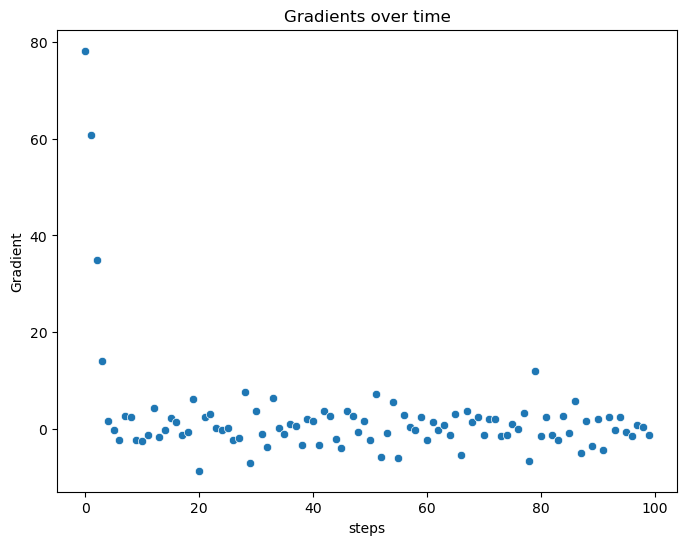

Fitted theta: [-0.9071599]


In [7]:
n = sampson_matrix.shape[0]
is_directed = True

number_of_edges_metric = NumberOfEdgesDirected() if is_directed else NumberOfEdgesUndirected()
fitted_model = ERGM(n, [number_of_edges_metric], is_directed=is_directed, n_networks_for_grad_estimation=500, n_mcmc_steps=50)

grads, _ = fitted_model.fit(sampson_matrix, lr=1, opt_steps=100, sliding_grad_window_k=20, sample_pct_growth=0.05)

grads = [x[0] for x in grads]


fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(grads, ax=ax)
ax.set(xlabel='steps', ylabel='Gradient')
ax.set_title("Gradients over time")

plt.show()

print(f"Fitted theta: {fitted_model._thetas}")

As we can see, our model reaches a theta that is extremely close to the actual R result.

## Now test a model with TotalReciprocity + NumberOfEdges

0.2875816993464052

optimization started
Step 0 - true_grad: 0, grad: [0. 0.], window_grad: 41.61 lr: 1.0000000000, thetas: [-1.71245054  2.47422053], time from start: 0.06, n_networks_for_grad_estimation: 500, sliding_grad_window_k: 20
Reached threshold of 0.001 after 76 steps. DONE!


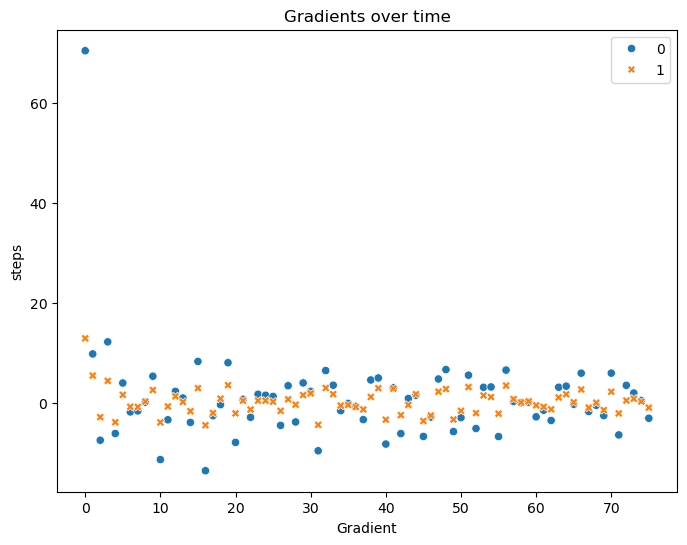

Fitted theta: [-1.71417226  2.28956868]


In [12]:
n = sampson_matrix.shape[0]
is_directed = True

number_of_edges_metric = NumberOfEdgesDirected() if is_directed else NumberOfEdgesUndirected()

estimated_p_seed = np.sum(sampson_matrix) / (n*(n-1))

fitted_model = ERGM(n, [number_of_edges_metric, TotalReciprocity()], is_directed=is_directed, n_networks_for_grad_estimation=500, n_mcmc_steps=100, seed_MCMC_proba=estimated_p_seed)
grads, _ = fitted_model.fit(sampson_matrix, lr=1, opt_steps=400, sliding_grad_window_k=20, sample_pct_growth=0.05, lr_decay_pct=0.1, steps_for_decay=10)

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(grads, ax=ax)
ax.set(xlabel='Gradient', ylabel='steps')
ax.set_title("Gradients over time")

plt.show()

print(f"Fitted theta: {fitted_model._thetas}")

#### Took a while (~1 minute), but results are pretty close!
True results in R -
* $\theta_1 = -1.7625$
* $\theta_2 = 2.3132$

## And finally we test the full $p_1$ model

optimization started
Step 0 - true_grad: 0, grad: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], window_grad: 1.82 lr: 0.0100000000, thetas: [-0.44194942  0.00513835  0.9250694   0.29300227  0.76951677 -0.58929952
  0.05503778  0.20919635  0.90454351  0.04609982  0.65168439  0.21686795
 -0.64361568  0.43986542 -0.02001994  0.72915113  0.58329544 -0.25479163
 -0.45998632 -0.17694399  0.14513448 -0.68115912  0.84953288 -0.61816976
  0.79403835 -0.80797874  0.02155744 -0.10975927  0.57408901  0.63494295
 -0.85251859 -0.97006676 -0.55119464  0.51198911 -1.06902592 -0.54173057], time from start: 0.10, n_networks_for_grad_estimation: 500, sliding_grad_window_k: 30
Step 100 - true_grad: 0, grad: [-5.50816697  0.25045372  0.67876588 -0.19419238  0.06533575 -0.71143376
  0.0399274  -1.45735027 -0.57168784 -0.22867514 -1.28856624 -0.33212341
 -0.11796733 -0.16878403 -0.54809437  0.14700544 -0.69147005 -0.46279492
 -0.38838475  0.21

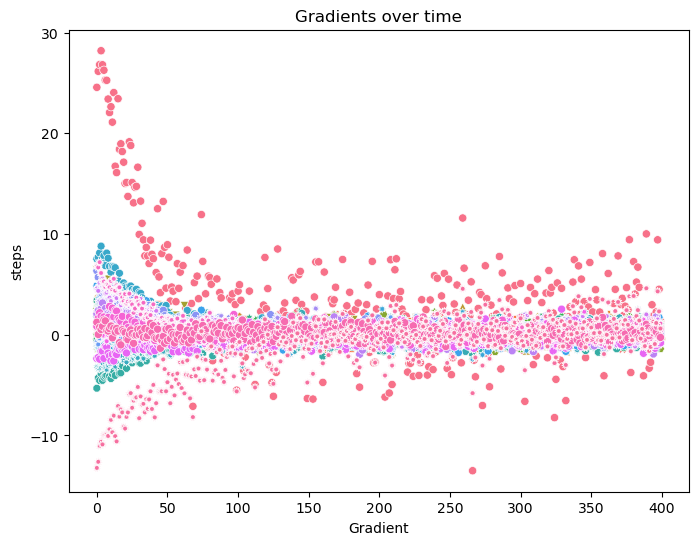

Fitted theta: [-1.17131471 -0.2262679   1.47670853  0.35833718  0.12727611  1.28362825
  0.61734147  1.41598833  0.68808506  2.18165308  1.54959607 -0.12197784
 -0.25458243  0.64055358  1.93417638  1.50292871  1.32302615  1.95298702
 -0.17774976 -3.27608425 -1.86711883 -0.89625674 -3.59857901 -1.70632079
 -2.44909197 -2.36544912 -4.19922684 -3.22153849 -1.03034019 -1.52830817
 -1.73000301 -3.49990138 -3.2341142  -3.61172338 -3.4767376   3.87216849]


In [24]:
n = sampson_matrix.shape[0]
is_directed = True



estimated_p_seed = np.sum(sampson_matrix) / (n*(n-1))

metrics = [NumberOfEdgesDirected(), OutDegree(), InDegree(), TotalReciprocity()]

fitted_model = ERGM(n, metrics, is_directed=is_directed, n_networks_for_grad_estimation=500, n_mcmc_steps=100, seed_MCMC_proba=estimated_p_seed)
grads, _ = fitted_model.fit(sampson_matrix, lr=0.01, opt_steps=400, sliding_grad_window_k=30, sample_pct_growth=0.05, lr_decay_pct=0.1, steps_for_decay=50, optimization_method="gradient_descent")

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(grads, ax=ax, legend=False)
ax.set(xlabel='steps', ylabel='Gradient')
ax.set_title("Gradients over time")
plt.show()

print(f"Fitted theta: {fitted_model._thetas}")

In [25]:
true_values = {"edges":      -1.1761,
"sender2":    -0.2945,
"sender3":     1.4141,
"sender4":     0.3662,
"sender5":     0.1315,
"sender6":     1.2148,
"sender7":     0.6055,
"sender8":     1.3609,
"sender9":     0.6402,
"sender10":    2.0639,
"sender11":    1.4355,
"sender12":   -0.1681,
"sender13":   -0.2322,
"sender14":    0.5841,
"sender15":    1.8600,
"sender16":    1.4317,
"sender17":    1.2211,
"sender18":    1.8724,
"receiver2":  -0.1522,
"receiver3":  -3.0453,
"receiver4":  -1.7596,
"receiver5":  -0.8198,
"receiver6":  -3.3922,
"receiver7":  -1.6074,
"receiver8":  -2.2656,
"receiver9":  -2.2069,
"receiver10": -3.9189,
"receiver11": -3.0257,
"receiver12": -0.9457,
"receiver13": -1.4749,
"receiver14": -1.5950,
"receiver15": -3.3147,
"receiver16": -3.0567,
"receiver17": -3.4436,
"receiver18": -3.3239,
"mutual":       3.6918
}

<Axes: >

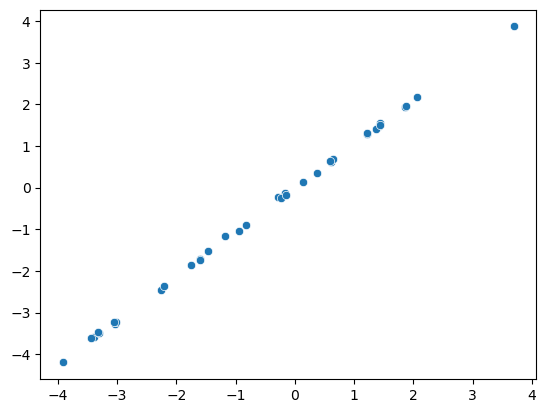

In [30]:
true_predictions = np.array(list(true_values.values()))

fitted_thetas = fitted_model._thetas

sns.scatterplot(x=true_predictions, y=fitted_thetas)

array([-1.17131471, -0.2262679 ,  1.47670853,  0.35833718,  0.12727611,
        1.28362825,  0.61734147,  1.41598833,  0.68808506,  2.18165308,
        1.54959607, -0.12197784, -0.25458243,  0.64055358,  1.93417638,
        1.50292871,  1.32302615,  1.95298702, -0.17774976, -3.27608425,
       -1.86711883, -0.89625674, -3.59857901, -1.70632079, -2.44909197,
       -2.36544912, -4.19922684, -3.22153849, -1.03034019, -1.52830817,
       -1.73000301, -3.49990138, -3.2341142 , -3.61172338, -3.4767376 ,
        3.87216849])

In [18]:
grads[-1, :]

array([ 0.79851669,  0.72435105,  0.90358467,  0.6526576 , -0.27564895,
        0.94437577, -0.29419036,  1.95302843, -0.47836836, -2.08899876,
        0.6934487 ,  0.        ,  0.14956737,  0.63658838, -0.9592089 ,
       -0.27935723,  0.41409147, -0.80098888, -2.41161928,  0.43634116,
        0.1421508 , -0.79851669,  2.23733004,  0.70210136,  1.31273177,
       -0.38071693,  1.55871446,  1.08899876, -1.14709518, -0.90976514,
        0.34239802,  1.22744129,  0.50803461,  2.6736712 ,  0.48207664,
       -2.18170581])